In [489]:
import matplotlib.pyplot as plt
import copy
import math
import numpy as np
from matplotlib.path import Path
from shapely import Point

# N, mm

fc = 24
fy = 400
cc = 50
b = 500
d = 800

X1starr = 3
X2ndarr = 0
Yarr = 5
Rebardia = 25

XTieLeg = 4
YTieLeg = 4
TieSpace = 100
Tiedia = 10
deff = (d-cc-Rebardia/2-Tiedia)
beff = (b-cc-Rebardia/2-Tiedia)

Es = 200000
εcu = 0.003                                 # ACI 318-19 (22.2.2.1)
εty = fy/Es  

Uls=    [30000,   0,   0,   300,   100]                      # Pu (Positive in Compression), Vux, Vuy, Mux, Muy
Pu = Uls[0]
Vux = Uls[1]
Vuy = Uls[2]
Mux = Uls[3]
Muy = Uls[4]
Mu = math.sqrt(Mux**2+Muy**2)

if Mux == 0 : 
    theta = 0
else : 
    theta = math.atan(abs(Muy)/abs(Mux))*180/math.pi

In [490]:
# Rebar Location

def Delete_Zero_Element(List) : 
    res = list(filter(lambda x: x != 0, List))
    return res

def Delete_Empty_List(List) : 
    res = list(filter(lambda x: x !=[], List))
    return res

def Rebar_Location_X(List) : 
    Lx = []
    for i in range(len(List)) :
        n = List[i]
        toappend=[]
        for j in range(n) : 
            if n == 0 :
                dx = 0
            else : 
                dx = (b-2*cc-Rebardia-2*Tiedia)/(n-1)*(j)+cc+Rebardia/2+Tiedia
            toappend.append(dx)
        Lx.append(toappend)
    return Delete_Empty_List(Lx)

def Rebar_Location_Y(List) : 
    Ly = [] 
    for i in range(len(List)) :
        n = List[i]
        toappend=[]
        for j in range(n) : 
            if n == 0 :
                dy = 0
            else : 
                dy = -((d-2*cc-Rebardia-2*Tiedia)/(Yarr-1)*i+cc+Rebardia/2+Tiedia)
            toappend.append(dy)
        Ly.append(toappend)
    return Delete_Empty_List(Ly)

def Composing_Rebar_Loca_List(X1starr, X2ndarr, Yarr) : 
    if X2ndarr > 0 : 
        YarrtoX = Yarr - 4
    else : 
        YarrtoX = Yarr - 2

    Rebararrcomb = [X1starr, X2ndarr] + [2]*YarrtoX + [X2ndarr, X1starr]

    if YarrtoX >= 0 :
        Rebararr = Delete_Zero_Element(Rebararrcomb)
        XCoord = Rebar_Location_X(Rebararr)
        YCoord = Rebar_Location_Y(Rebararr)
    else : 
        Rebararr = 0
        XCoord = 0
        YCoord = 0

    return Rebararr, XCoord, YCoord

def Composing_Rebar_Coord_Dict(List1, List2) :
    n = len(List1)
    NameKeyList = []
    CoordDictList = []
    for i in range(n) : 
        for j in range(len(List1[i])) :
            NameKey = f'Bar_{i}_{j}'
            DictKey = ['X_Coord', 'Y_Coord']
            DictVal = [List1[i][j], List2[i][j]]
            CoordDict = dict(zip(DictKey, DictVal))
            NameKeyList.append(NameKey)
            CoordDictList.append(CoordDict)
    Dict = dict(zip(NameKeyList, CoordDictList))
    return Dict

def Conc_Edge_Dict(b, d) :
    n = 4
    NameKey_List = []
    CoordDict_List = []
    X_Coord = [0, b, b, 0]
    Y_Coord = [0, 0, -d, -d]
    for i in range(n) : 
        NameKey = f'Conc_{i}'
        DictKey = ['X_Coord', 'Y_Coord']
        DictVal = [X_Coord[i], Y_Coord[i]]
        Coord_Dict = dict(zip(DictKey, DictVal))
        NameKey_List.append(NameKey)
        CoordDict_List.append(Coord_Dict)
        Dict = dict(zip(NameKey_List, CoordDict_List))
    return Dict

Rebararr, XCoord, YCoord = Composing_Rebar_Loca_List(X1starr, X2ndarr, Yarr)
RebarCoordDict = Composing_Rebar_Coord_Dict(XCoord, YCoord)
ConcCoordDict = Conc_Edge_Dict(b, d)

In [491]:
# Sectional information

Ag = b*d
As = math.pi*(Rebardia/2)**2
Asv = math.pi*(Tiedia/2)**2
Ast = As*(sum(Rebararr))

In [492]:
def Define_Stress_Block_Coeff(fc) :         # ACI 318-19 (Table 22.2.2.4.3)
    if 17 < fc <= 28 :                  
        β1 = 0.85
    elif 28 < fc <= 55 :
        β1 = 0.85-0.05*(fc-28)/7
    else : 
        β1 = 0.65
    return β1

def Define_Axial_Str_Reduction(εsbot, εty) :        # ACI 318-19 (Table 21.2.2) 
    if εsbot <= εty :
        PhiP = 0.65
    elif εty < εsbot <= εty+0.003 :
        PhiP = 0.65+0.25*(εsbot-εty)/0.003
    else : 
        PhiP = 0.9
    return PhiP

def Define_c(εsbot, εcu, d1) : 
    c = d1/(εsbot+εcu)*εcu
    return c

def Define_Comp_Conc_Force(a, b, d, ConcExtFiberDis, ConcIntFiberDis) : 

    b_ = b/abs(math.cos(theta*math.pi/180))
    d_ = d/abs(math.cos((90-theta)*math.pi/180))

    if theta <= math.atan(d/b)*180/math.pi : 
        if ConcExtFiberDis - ConcIntFiberDis == 0 :
            Ac = a*b
        elif a <= ConcExtFiberDis - ConcIntFiberDis : 
            Ac = a*((a/(ConcExtFiberDis - ConcIntFiberDis))*b_/2)
        elif ConcExtFiberDis - ConcIntFiberDis < a < ConcExtFiberDis + ConcIntFiberDis : 
            Ac = ((b*d/2)-(b_*(ConcExtFiberDis-a)))
        elif ConcExtFiberDis + ConcIntFiberDis <= a : 
            Ac = ((b*d)-((ConcExtFiberDis*2-a)*((ConcExtFiberDis*2-a)/(ConcExtFiberDis - ConcIntFiberDis)))*b_/2)

    elif math.atan(d/b)*180/math.pi < theta <= 90  : 
        if ConcExtFiberDis - ConcIntFiberDis == 0 :
            Ac = a*d
        elif a <= ConcExtFiberDis - ConcIntFiberDis : 
            Ac = a*((a/(ConcExtFiberDis - ConcIntFiberDis))*d_/2)
        elif ConcExtFiberDis - ConcIntFiberDis < a < ConcExtFiberDis + ConcIntFiberDis : 
            Ac = ((b*d/2)-(d_*(ConcExtFiberDis-a)))
        elif ConcExtFiberDis + ConcIntFiberDis <= a : 
            Ac = ((b*d)-((ConcExtFiberDis*2-a)*((ConcExtFiberDis*2-a)/(ConcExtFiberDis - ConcIntFiberDis)))*d_/2)

    Cc = 0.85*fc*Ac
    return b_, d_, Ac, Cc

def Define_Steel_Strain(c, εcu, RebarDict, Rebararr, εsbot, ConcExtFiberDis, d1) : 
    n = len(Rebararr)
    for i in range(n) : 
        for j in range(Rebararr[i]) :
            key = f'Bar_{i}_{j}'
            if abs(ConcExtFiberDis - RebarDict[key]['Y_Coord']) == d1 : 
                RebarDict[key]['εs'] = abs(εsbot)
            else : 
                RebarDict[key]['εs'] = abs((c-(abs(ConcExtFiberDis - RebarDict[key]['Y_Coord'])))*εcu/c)
    return RebarDict

def Define_Steel_Attr_Str(Es, εty, fy, RebarDict, Rebararr) :
    n = len(Rebararr)
    for i in range(n) : 
        for j in range(Rebararr[i]) :
            key = f'Bar_{i}_{j}'
            if abs(RebarDict[key]['εs']) <= εty :
                fy_ = RebarDict[key]['εs']*Es
                RebarDict[key]['fy'] = fy_
            else : 
                fy_ = fy
                RebarDict[key]['fy'] = fy_
    return RebarDict

def Define_Comp_Steel_Force(c, a, RebarDict, Rebararr, ConcExtFiberDis) :
    toappend = []
    n = len(Rebararr)
    for i in range(n) : 
        for j in range(Rebararr[i]) :
            key = f'Bar_{i}_{j}'
            if abs(ConcExtFiberDis - RebarDict[key]['Y_Coord']) > c :
                RebarDict[key]['Comp'] = 0
            else : 
                if abs(ConcExtFiberDis - RebarDict[key]['Y_Coord']) > a :
                    RebarDict[key]['Comp'] = RebarDict[key]['fy']*As
                else : 
                    RebarDict[key]['Comp'] = (RebarDict[key]['fy']-0.85*fc)*As
            toappend.append(RebarDict[key]['Comp'])
    return sum(toappend)

def Define_Tens_Steel_Force(c, a, RebarDict, Rebararr, ConcExtFiberDis) :
    toappend = []
    n = len(Rebararr)
    for i in range(n) : 
        for j in range(Rebararr[i]) :
            key = f'Bar_{i}_{j}'
            if abs(ConcExtFiberDis - RebarDict[key]['Y_Coord']) < c :
                RebarDict[key]['Tens'] = 0
            else : 
                if abs(ConcExtFiberDis - RebarDict[key]['Y_Coord']) > a :
                    RebarDict[key]['Tens'] = RebarDict[key]['fy']*As
                else : 
                    RebarDict[key]['Tens'] = (RebarDict[key]['fy']-0.85*fc)*As
            toappend.append(RebarDict[key]['Tens'])
    return sum(toappend)

def Define_Conc_Moment(a, b_, d_, Ac, Cc, ConcExtFiberDis, ConcIntFiberDis) : 
    if theta <= math.atan(d/b)*180/math.pi : 
        if ConcExtFiberDis - ConcIntFiberDis == 0 :
            dis = ConcExtFiberDis - a/2
        elif a <= ConcExtFiberDis - ConcIntFiberDis : 
            dis = ConcExtFiberDis - 2*a/3
        elif ConcExtFiberDis - ConcIntFiberDis < a < ConcExtFiberDis + ConcIntFiberDis : 
            dis = ((b_*(ConcExtFiberDis-ConcIntFiberDis)/2)*(ConcExtFiberDis - 2*(ConcExtFiberDis-ConcIntFiberDis)/3)+(b_*(a-(ConcExtFiberDis-ConcIntFiberDis))*(ConcIntFiberDis+(ConcExtFiberDis-a))/2))/Ac
        elif ConcExtFiberDis + ConcIntFiberDis <= a : 
            dis = ((b*d)-Ac)*((a-ConcExtFiberDis)+(2*ConcExtFiberDis-a)/3)/Ac

    elif math.atan(d/b)*180/math.pi < theta <= 90  : 
        if ConcExtFiberDis - ConcIntFiberDis == 0 :
            dis = ConcExtFiberDis - a/2
        elif a <= ConcExtFiberDis - ConcIntFiberDis : 
            dis = ConcExtFiberDis - 2*a/3
        elif ConcExtFiberDis - ConcIntFiberDis < a < ConcExtFiberDis + ConcIntFiberDis : 
            dis = ((d_*(ConcExtFiberDis-ConcIntFiberDis)/2)*(ConcExtFiberDis - 2*(ConcExtFiberDis-ConcIntFiberDis)/3)+(d_*(a-(ConcExtFiberDis-ConcIntFiberDis))*(ConcIntFiberDis+(ConcExtFiberDis-a))/2))/Ac
        elif ConcExtFiberDis + ConcIntFiberDis <= a : 
            dis = ((b*d)-Ac)*((a-ConcExtFiberDis)+(2*ConcExtFiberDis-a)/3)/Ac
    Mc = Cc*dis
    return Mc

def Define_Steel_Moment(RebarDict, Rebararr) :                     # y Coordination 부호에 의한 Moment 계산
    toappend = []
    n = len(Rebararr)
    for i in range(n) : 
        for j in range(Rebararr[i]) :
            key = f'Bar_{i}_{j}'
            if RebarDict[key]['Y_Coord'] >= 0 :
                RebarDict[key]['Mom'] = (RebarDict[key]['Comp']-RebarDict[key]['Tens'])*abs(RebarDict[key]['Y_Coord'])
            else : 
                RebarDict[key]['Mom'] = (RebarDict[key]['Tens']-RebarDict[key]['Comp'])*abs(RebarDict[key]['Y_Coord'])
            toappend.append(RebarDict[key]['Mom'])
    return sum(toappend)

def Define_Centroid_x(fy, fc, Ag, As, b, RebarDict, Rebararr) : 
    Fc = 0.85*fc*Ag
    Fs = As*fy
    Cent = b/2
    n = len(Rebararr)
    toappend = []
    for i in range(n) : 
        for j in range(Rebararr[i]) :
            key = f'Bar_{i}_{j}'
            Mominer = abs(RebarDict[key]['X_Coord'])*Fs
            toappend.append(Mominer)
    x = (Fc*Cent+sum(toappend))/(Fc+sum(Rebararr)*Fs)
    return x

def Define_Centroid_y(fy, fc, Ag, As, d, RebarDict, Rebararr) : 
    Fc = 0.85*fc*Ag
    Fs = As*fy
    Cent = d/2
    n = len(Rebararr)
    toappend = []
    for i in range(n) : 
        for j in range(Rebararr[i]) :
            key = f'Bar_{i}_{j}'
            Mominer = abs(RebarDict[key]['Y_Coord'])*Fs
            toappend.append(Mominer)
    y = (Fc*Cent+sum(toappend))/(Fc+sum(Rebararr)*Fs)
    return y

In [493]:
def Composing_Coord_Dict_about_Cent(x, y, RebarDict, Rebararr, ConcDict) : 
    n = len(Rebararr)
    m = 4
    for i in range(n) : 
        for j in range(Rebararr[i]) :
            key = f'Bar_{i}_{j}'
            RebarDict[key]['X_Coord'] = RebarDict[key]['X_Coord']-x
            RebarDict[key]['Y_Coord'] = RebarDict[key]['Y_Coord']+y
    for i in range(m) : 
        key = f'Conc_{i}'
        ConcDict[key]['X_Coord'] = ConcDict[key]['X_Coord']-x
        ConcDict[key]['Y_Coord'] = ConcDict[key]['Y_Coord']+y
    return RebarDict

def Coord_Dict_Translation(fy, fc, Ag, As, b, d, RebarCoordDict, Rebararr, ConcCoordDict) : 
    RebarDict = copy.deepcopy(RebarCoordDict)
    ConcDict = copy.deepcopy(ConcCoordDict)
    x = Define_Centroid_x(fy, fc, Ag, As, b, RebarDict, Rebararr)
    y = Define_Centroid_y(fy, fc, Ag, As, d, RebarDict, Rebararr)
    Composing_Coord_Dict_about_Cent(x, y, RebarDict, Rebararr, ConcDict)
    return x, y, RebarDict, ConcDict

def Lotated_Coord_about_Cent(theta, RebarDict, Rebararr, ConcDict) : 
    RebarDictRotate = copy.deepcopy(RebarDict)
    ConcDictRotate = copy.deepcopy(ConcDict)
    n = len(Rebararr)
    m = 4
    for i in range(n) : 
        for j in range(Rebararr[i]) :
            key = f'Bar_{i}_{j}'
            RebarDictRotate[key]['X_Coord'] = RebarDict[key]['X_Coord']*math.cos(theta*math.pi/180)-RebarDict[key]['Y_Coord']*math.sin(theta*math.pi/180)
            RebarDictRotate[key]['Y_Coord'] = RebarDict[key]['X_Coord']*math.sin(theta*math.pi/180)+RebarDict[key]['Y_Coord']*math.cos(theta*math.pi/180)
    for i in range(m) : 
        key = f'Conc_{i}'
        ConcDictRotate[key]['X_Coord'] = ConcDict[key]['X_Coord']*math.cos(theta*math.pi/180)-ConcDict[key]['Y_Coord']*math.sin(theta*math.pi/180)
        ConcDictRotate[key]['Y_Coord'] = ConcDict[key]['X_Coord']*math.sin(theta*math.pi/180)+ConcDict[key]['Y_Coord']*math.cos(theta*math.pi/180)
    return RebarDictRotate, ConcDictRotate

def Find_Max_Min_Distance(RebarDict, Rebararr, ConcDict) : 
    toappendRebar = []
    toappendConc = []
    n = len(Rebararr)
    m = 4
    for i in range(n) : 
        for j in range(Rebararr[i]) :
            key = f'Bar_{i}_{j}'
            YRebar = abs(RebarDict[key]['Y_Coord'])
            toappendRebar.append(YRebar)
    for i in range(m) : 
        key = f'Conc_{i}'
        YConc = abs(ConcDict[key]['Y_Coord'])
        toappendConc.append(YConc)
    return max(toappendRebar), max(toappendConc), min(toappendConc)

In [494]:
def Max_Comp_Case(fy, fc, Ag, Ast) : 
    Phi = 0.65

    Po = 0.85*fc*(Ag-Ast)+fy*Ast                   # ACI 318-19 (22.4.2.2) Nominal Axial Compressive Strength
    Mo = 0
    Pn = 0.8 * Po                                  # Factored axial compressive strength at zero eccentricity
    Mn = 0

    ΦPo = Phi*Po
    ΦMo = 0
    ΦPn = Phi*Pn                                   # ACI 318-19 (Table 22.4.2.1) Maximum (allowable) factored axial compressive strength
    ΦMn = 0
    return Pn, Mn, ΦPn, ΦMn, Po, Mo, ΦPo, ΦMo

In [495]:
def P_M_Points(fy, fc, Es, εcu, εsbot, Ag, Ast, RebarDict, Rebararr, d1, ConcExtFiberDis, ConcIntFiberDis) : 
    RebarDictCopy = copy.deepcopy(RebarDict)
    εty = fy/Es                                    # ACI 318-19 (22.2.1)
    Pnmax = 0.8*(0.85*fc*(Ag-Ast)+fy*Ast)
    β1 = Define_Stress_Block_Coeff(fc)

    c = Define_c(εsbot, εcu, d1)
    a = β1*c                                       # ACI 318-19 (22.2.2.4.1)

    Define_Steel_Strain(c, εcu, RebarDictCopy, Rebararr, εsbot, ConcExtFiberDis, d1)
    Define_Steel_Attr_Str(Es, εty, fy, RebarDictCopy, Rebararr)
    Phi = Define_Axial_Str_Reduction(εsbot, εty)

    b_, d_, Ac, Cc = Define_Comp_Conc_Force(a, b, d, ConcExtFiberDis, ConcIntFiberDis)
    Cs = Define_Comp_Steel_Force(c, a, RebarDictCopy, Rebararr, ConcExtFiberDis)
    Ts = Define_Tens_Steel_Force(c, a, RebarDictCopy, Rebararr, ConcExtFiberDis)
    Mc = Define_Conc_Moment(a, b_, d_, Ac, Cc, ConcExtFiberDis, ConcIntFiberDis)
    Ms = Define_Steel_Moment(RebarDictCopy, Rebararr)

    Pn = Cc+Cs-Ts
    Mn = Mc+Ms

    ΦPnmax = Phi*Pnmax
    ΦPn1 = Phi*Pn
    
    if ΦPn1 >= ΦPnmax : 
        ΦPn = ΦPnmax
    else : 
        ΦPn = ΦPn1
        
    ΦMn = Phi*Mn

    return Pn, Mn, ΦPn, ΦMn, ΦPn1

In [496]:
def Pure_Tension_Case(fy, Ast) :
    Phi = 0.9

    Pn = -fy*Ast                               # ACI 318-19 (22.4.3.1)
    Mn = 0
    ΦPn = Phi*Pn               # ACI 318-19 (Table 22.4.2.1) Maximum (allowable) factored axial compressive strength
    ΦMn = 0
    return Pn, Mn, ΦPn, ΦMn

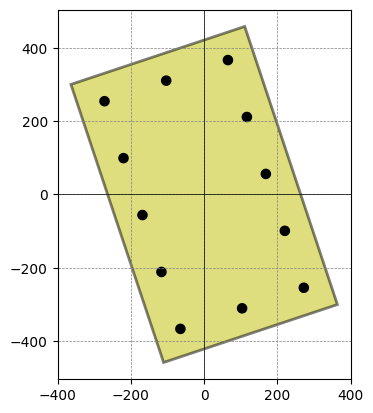

{'Bar_0_0': {'X_Coord': -177.5, 'Y_Coord': 327.5}, 'Bar_0_1': {'X_Coord': 0.0, 'Y_Coord': 327.5}, 'Bar_0_2': {'X_Coord': 177.5, 'Y_Coord': 327.5}, 'Bar_1_0': {'X_Coord': -177.5, 'Y_Coord': 163.75}, 'Bar_1_1': {'X_Coord': 177.5, 'Y_Coord': 163.75}, 'Bar_2_0': {'X_Coord': -177.5, 'Y_Coord': 0.0}, 'Bar_2_1': {'X_Coord': 177.5, 'Y_Coord': 0.0}, 'Bar_3_0': {'X_Coord': -177.5, 'Y_Coord': -163.75}, 'Bar_3_1': {'X_Coord': 177.5, 'Y_Coord': -163.75}, 'Bar_4_0': {'X_Coord': -177.5, 'Y_Coord': -327.5}, 'Bar_4_1': {'X_Coord': 0.0, 'Y_Coord': -327.5}, 'Bar_4_2': {'X_Coord': 177.5, 'Y_Coord': -327.5}}
{'Bar_0_0': {'X_Coord': -271.95587877448065, 'Y_Coord': 254.56335164355454}, 'Bar_0_1': {'X_Coord': -103.56459337051443, 'Y_Coord': 310.6937801115433}, 'Bar_0_2': {'X_Coord': 64.82669203345178, 'Y_Coord': 366.824208579532}, 'Bar_1_0': {'X_Coord': -220.17358208922343, 'Y_Coord': 99.2164615877829}, 'Bar_1_1': {'X_Coord': 116.60898871870899, 'Y_Coord': 211.47731852376037}, 'Bar_2_0': {'X_Coord': -168.3912

In [497]:
########### 회전된 Conc 단면 그리기 ############

x, y, RebarDict, ConcDict = Coord_Dict_Translation(fy, fc, Ag, As, b, d, RebarCoordDict, Rebararr, ConcCoordDict)
RebarDictRotate, ConcDictRotate = Lotated_Coord_about_Cent(theta, RebarDict, Rebararr, ConcDict)
Rebar_Ext_Fiber_Dis, ConcExtFiberDis, ConcIntFiberDis = Find_Max_Min_Distance(RebarDictRotate, Rebararr, ConcDictRotate)
d1 = ConcExtFiberDis + Rebar_Ext_Fiber_Dis
d2 = ConcExtFiberDis - Rebar_Ext_Fiber_Dis

ax = plt.subplot()
m = 4
Conc_X_Coord = []
Conc_Y_Coord = []
for i in range(m):
    key = f'Conc_{i}'
    Conc_X_Coord.append(ConcDictRotate[key]['X_Coord'])
    Conc_Y_Coord.append(ConcDictRotate[key]['Y_Coord'])
ax.fill(Conc_X_Coord, Conc_Y_Coord, color='y', alpha=0.5, edgecolor='k', linewidth=2)
n = len(Rebararr)
for i in range(n):
    for j in range(Rebararr[i]) :
        key = f'Bar_{i}_{j}'
        ax.fill(*Point(RebarDictRotate[key]['X_Coord'],RebarDictRotate[key]['Y_Coord']).buffer(Rebardia/2).exterior.xy, color = 'k')
ax.axhline(0, color='black', linewidth=0.5)
ax.axvline(0, color='black', linewidth=0.5)
ax.grid(color = 'gray', linestyle = '--', linewidth = 0.5)
ax.set_aspect('equal', adjustable='box')
plt.show()

print(RebarDict)
print(RebarDictRotate)

print(ConcExtFiberDis, ConcIntFiberDis)

########### 회전된 Conc 단면 그리기 ############

In [498]:
def Diagram_Point(fy, fc, Es, εcu, εty, Ag, Ast, d1, d2, n, RebarDictRotate, Rebararr, ConcExtFiberDis, ConcIntFiberDis) :
    εty = fy/Es   
    tenslimit = (εcu+εty)*d1/d2
    complimit = -εcu*((d1+d2)/0.85-d1)/((d1+d2)/0.85)
    res = []
    for i in range(n) :
        Pn, Mn, ΦPn, ΦMn, ΦPn1 = P_M_Points(fy, fc, Es, εcu, complimit+(tenslimit+complimit)/(n)*i, Ag, Ast, RebarDictRotate, Rebararr, d1, ConcExtFiberDis, ConcIntFiberDis)
        toappend = [Pn, Mn, ΦPn, ΦMn, ΦPn1]
        res.append(toappend)
    return res

def is_on_boundary(point, path, tol=1e-9):
    for i in range(len(path.vertices)):
        # 경계의 두 점
        startpoint = path.vertices[i - 1]
        endpoint = path.vertices[i]
        # 직선 방정식으로 거리 계산
        line_vec = np.array(endpoint) - np.array(startpoint)
        point_vec = np.array(point) - np.array(startpoint)
        proj = np.dot(point_vec, line_vec) / np.dot(line_vec, line_vec)
        closest_point = startpoint + proj * line_vec
        if np.linalg.norm(np.array(point) - closest_point) < tol and 0 <= proj <= 1:
            return True
    return False

In [499]:
############ PM Diagram Point List 구성 ############

n = 200

Pn_C, Mn_C, ΦPn_C, ΦMn_C, Po, Mo, ΦPo, ΦMo = Max_Comp_Case(fy, fc, Ag, Ast)
Pn_T, Mn_T, ΦPn_T, ΦMn_T = Pure_Tension_Case(fy, Ast)

Pn_C_fymodi, Mn_C_fymodi, ΦPn_C_fymodi, ΦMn_C_fymodi, Po_fymodi, Mo_fymodi, ΦPo_fymodi, ΦMo_fymodi = Max_Comp_Case(1.25*fy, fc, Ag, Ast)
Pn_T_fymodi, Mn_T_fymodi, ΦPn_T_fymodi, ΦMn_T_fymodi = Pure_Tension_Case(1.25*fy, Ast)

DP1 = Diagram_Point(fy, fc, Es, εcu, εty, Ag, Ast, d1, d2, n, RebarDictRotate, Rebararr, ConcExtFiberDis, ConcIntFiberDis)
DP2 = Diagram_Point(1.25*fy, fc, Es, εcu, εty, Ag, Ast, d1, d2, n, RebarDictRotate, Rebararr, ConcExtFiberDis, ConcIntFiberDis)

x_Phi1 = [ΦMn_C] + [DP1[i][3] for i in range(n)] + [ΦMn_T]
y_Phi1 = [ΦPn_C] + [DP1[i][2] for i in range(n)] + [ΦPn_T]

x_Phi2 = [ΦMo] + [DP1[i][3] for i in range(n)] + [ΦMn_T]
y_Phi2 = [ΦPo] + [DP1[i][4] for i in range(n)] + [ΦPn_T]

x_NoPhi = [Mo] + [DP1[i][1] for i in range(n)] + [Mn_T]
y_NoPhi = [Po] + [DP1[i][0] for i in range(n)] + [Pn_T]

x_fymodi = [Mo_fymodi] + [DP2[i][1] for i in range(n)] + [Mn_T_fymodi]
y_fymodi = [Po_fymodi] + [DP2[i][0] for i in range(n)] + [Pn_T_fymodi]

point = [Mu, Pu]

vertices = list(zip(x_Phi1,y_Phi1))
path = Path(vertices)

print(DP1)

############ PM Diagram Point List 구성 ############

[[9867780.599569526, 130943642.5368431, 5405934.857020118, 85113367.64894803, 6414057.389720192], [9519622.240622373, 244062908.51079553, 5405934.857020118, 158640890.5320171, 6187754.456404543], [8885970.281755798, 440251150.82973814, 5405934.857020118, 286163248.0393298, 5775880.683141269], [8153936.938078359, 634234113.5070822, 5300059.009750933, 412252173.7796035, 5300059.009750933], [7504801.581351763, 776909021.0223559, 4878121.027878646, 504990863.66453135, 4878121.027878646], [6913153.490671273, 884087169.4320074, 4493549.768936328, 574656660.1308049, 4493549.768936328], [6373409.112189687, 963556428.3384405, 4142715.9229232967, 626311678.4199864, 4142715.9229232967], [5890500.950313205, 1022609530.00092, 3828825.617703583, 664696194.5005981, 3828825.617703583], [5436259.382939588, 1068260920.2465968, 3533568.5989107327, 694369598.160288, 3533568.5989107327], [5020253.778267074, 1101538129.231976, 3263164.9558735983, 715999784.0007844, 3263164.9558735983], [4622460.462289564, 1

In [500]:
# SAP_500x500x3x3_0degree = [[-3434462,		0],
#                             [-3434462,		1.36E+08],
#                             [-3135408,		2.07E+08],
#                             [-2641454,		2.65E+08],
#                             [-2097074,		3.10E+08],
#                             [-1477737,		3.46E+08],
#                             [-1265375,		3.85E+08],
#                             [-838407,		4.11E+08],
#                             [-226816,		3.25E+08],
#                             [635113,	1.65E+08],
#                             [1427040,		0]]
# SAP_500x500x3x3_30degree = [[-3434462,		0],
#                             [-3434462,		69582208.92],
#                             [-3434462,		137048300.3],
#                             [-3014514,		214713879.4],
#                             [-2266972,		274802274.4],
#                             [-1404054,		300270028.5],
#                             [-804416,		321677167.4],
#                             [-70888,		295864462.2],
#                             [721677,		173054240.1],
#                             [1220349,		58188319.54],
#                             [1427040,		0]]
# SAP_500x500x3x3_75degree = [[-3434462,		0],
#                             [-3434462,		80368054.42],
#                             [-3426214,		162160013.9],
#                             [-2843285,		239945472.2],
#                             [-2204533,		292203507.8],
#                             [-1459335,		320703336.1],
#                             [-1005956,		354044502.5],
#                             [-404557	,	343003647.2],
#                             [439623,		213383250.3],
#                             [1189464,		65873177.83],
#                             [1427040	,	0]]

# x_SAP_0degree = [SAP_500x500x3x3_0degree[i][1] for i in range(11)]
# y_SAP_0degree = [-SAP_500x500x3x3_0degree[i][0] for i in range(11)]

# x_SAP_30degree = [SAP_500x500x3x3_30degree[i][1] for i in range(11)]
# y_SAP_30degree = [-SAP_500x500x3x3_30degree[i][0] for i in range(11)]

# x_SAP_75degree = [SAP_500x500x3x3_75degree[i][1] for i in range(11)]
# y_SAP_75degree = [-SAP_500x500x3x3_75degree[i][0] for i in range(11)]


# SAP_800x800x8x8_0degree = [[-9509972,	0],
#                             [-9509972,	6.44E+08],
#                             [-8617298,	9.61E+08],
#                             [-7299211,	1.23E+09],
#                             [-5840151,	1.45E+09],
#                             [-4112063,	1.65E+09],
#                             [-3322420,	1.89E+09],
#                             [-2216361,	2.08E+09],
#                             [-482194,	1.75E+09],
#                             [1906371,	1.06E+09],
#                             [4962240,	0]]

# SAP_800x800x8x8_30degree = [[-9509972,	0],
#                             [-9509972,	362597642],
#                             [-9509972,	641447433.5],
#                             [-8378468,	970896956.4],
#                             [-6445922,	1264272914],
#                             [-4179893,	1439335249],
#                             [-2363113,	1635154990],
#                             [-82747,	1579577162],
#                             [2287786,	1007405445],
#                             [4235875,	328950589],
#                             [4962240,	0]]

# SAP_800x800x8x8_75degree = [[-9509972,	0],
#                             [-9509972,	410289032.3],
#                             [-9408517,	747855881.8],
#                             [-7892634,	1093044414],
#                             [-6202875,	1350646841],
#                             [-4235923,	1534794152],
#                             [-2824920,	1777988495],
#                             [-1020006,	1797244060],
#                             [1465206,	1208613652],
#                             [3981818,	418014365.8],
#                             [4962240,	0]]

# x_SAP_0degree = [SAP_800x800x8x8_0degree[i][1] for i in range(11)]
# y_SAP_0degree = [-SAP_800x800x8x8_0degree[i][0] for i in range(11)]

# x_SAP_30degree = [SAP_800x800x8x8_30degree[i][1] for i in range(11)]
# y_SAP_30degree = [-SAP_800x800x8x8_30degree[i][0] for i in range(11)]

# x_SAP_75degree = [SAP_800x800x8x8_75degree[i][1] for i in range(11)]
# y_SAP_75degree = [-SAP_800x800x8x8_75degree[i][0] for i in range(11)]


# SAP_800x500x3x3_0degree = [[-5018556,	0],
#                             [-5018556,	3.00E+08],
#                             [-4709838,	4.76E+08],
#                             [-4026910,	6.12E+08],
#                             [-3299529,	7.11E+08],
#                             [-2510655,	7.80E+08],
#                             [-2234024,	8.70E+08],
#                             [-1775788,	9.44E+08],
#                             [-984531,	7.92E+08],
#                             [-13213,	4.99E+08],
#                             [1414080,	0]]


# SAP_800x500x3x3_30degree = [[-5018556,	0],
#                             [-5018556,	145100051.4],
#                             [-5018556,	314776044.6],
#                             [-4417736,	515732459.8],
#                             [-3482554,	652034761.3],
#                             [-2460466,	713908432.5],
#                             [-1822204,	780189496.2],
#                             [-990313,	732759073.6],
#                             [141346,	445805978],
#                             [1039102,	149174156.4],
#                             [1414080,	0]]


# SAP_800x500x3x3_75degree = [[-5018556,	0],
#                             [-5018556,	108635379.3],
#                             [-5018556,	234117321],
#                             [-4436314,	353445059.4],
#                             [-3444188,	432302590.8],
#                             [-2344540,	465745102],
#                             [-1652488,	505508951.5],
#                             [-729456,	490475942.3],
#                             [397370,	311134215.4],
#                             [1104151,	120411825.8],
#                             [1414080,	0]]


# x_SAP_0degree = [SAP_800x500x3x3_0degree[i][1] for i in range(11)]
# y_SAP_0degree = [-SAP_800x500x3x3_0degree[i][0] for i in range(11)]

# x_SAP_30degree = [SAP_800x500x3x3_30degree[i][1] for i in range(11)]
# y_SAP_30degree = [-SAP_800x500x3x3_30degree[i][0] for i in range(11)]

# x_SAP_75degree = [SAP_800x500x3x3_75degree[i][1] for i in range(11)]
# y_SAP_75degree = [-SAP_800x500x3x3_75degree[i][0] for i in range(11)]


# SAP_500x500x5x3_0degree = [[-3836352,	0],
#                             [-3836352,	1.74E+08],
#                             [-3404801,	2.50E+08],
#                             [-2847757,	3.20E+08],
#                             [-2215196,	3.81E+08],
#                             [-1464120,	4.42E+08],
#                             [-1247863,	4.96E+08],
#                             [-778357,	5.37E+08],
#                             [-57876,	4.30E+08],
#                             [1110661,	2.13E+08],
#                             [2160000,	0]]

# SAP_500x500x5x3_30degree = [[-3836352,	0],
#                             [-3836352,	94765792.32],
#                             [-3836352,	166336826.7],
#                             [-3272562,	251291424.4],
#                             [-2434187,	322884313.6],
#                             [-1428105,	362801350.6],
#                             [-670689,	400179522.2],
#                             [215013,	373565911.2],
#                             [1227669,	217256760.5],
#                             [1953309,	58188319.54],
#                             [2160000,	0]]

# SAP_500x500x5x3_75degree = [[-3836352,	0],
#                             [-3836352,	92298599.59],
#                             [-3752577,	176712794.4],
#                             [-3111338,	256408783.7],
#                             [-2379003,	311500536.6],
#                             [-1483387,	345257765.3],
#                             [-837798,	388415293.2],
#                             [26145,	377805571.7],
#                             [1070507,	230091394.9],
#                             [1922424,	65873177.83],
#                             [2160000,	0]]

# x_SAP_0degree = [SAP_500x500x5x3_0degree[i][1] for i in range(11)]
# y_SAP_0degree = [-SAP_500x500x5x3_0degree[i][0] for i in range(11)]

# x_SAP_30degree = [SAP_500x500x5x3_30degree[i][1] for i in range(11)]
# y_SAP_30degree = [-SAP_500x500x5x3_30degree[i][0] for i in range(11)]

# x_SAP_75degree = [SAP_500x500x5x3_75degree[i][1] for i in range(11)]
# y_SAP_75degree = [-SAP_500x500x5x3_75degree[i][0] for i in range(11)]

# SAP_800x500x3x5_0degree = [[-5427552,	0.00E+00],
#                             [-5427552,	3.24E+08],
#                             [-5043880,	5.07E+08],
#                             [-4314860,	6.47E+08],
#                             [-3494944,	7.53E+08],
#                             [-2572051,	8.33E+08],
#                             [-2098966,	9.45E+08],
#                             [-1479405,	1.02E+09],
#                             [-450794,	8.31E+08],
#                             [720288,	5.03E+08],
#                             [2160000,	0]]


# SAP_800x500x3x5_30degree = [[-5427552,	0],
#                             [-5427552,	165097484.3],
#                             [-5427552,	339422767.9],
#                             [-4692520,	544406484.2],
#                             [-3667366,	687198384.7],
#                             [-2512858,	756774874.1],
#                             [-1692714,	840656892],
#                             [-582650,	797087924.9],
#                             [730439,	481340212.3],
#                             [1781566,	150528230.2],
#                             [2160000,	0]]


# SAP_800x500x3x5_75degree = [[-5427552,	0],
#                             [-5427552,	133717635.8],
#                             [-5427552,	263904622.9],
#                             [-4696115,	393721856.1],
#                             [-3613259,	485470905.4],
#                             [-2378678,	535981380.3],
#                             [-1537259,	592156980.9],
#                             [-487706,	575973063.6],
#                             [846734,	368645208.8],
#                             [1839012,	123452854.1],
#                             [2160000,	0]]

# x_SAP_0degree = [SAP_800x500x3x5_0degree[i][1] for i in range(11)]
# y_SAP_0degree = [-SAP_800x500x3x5_0degree[i][0] for i in range(11)]

# x_SAP_30degree = [SAP_800x500x3x5_30degree[i][1] for i in range(11)]
# y_SAP_30degree = [-SAP_800x500x3x5_30degree[i][0] for i in range(11)]

# x_SAP_75degree = [SAP_800x500x3x5_75degree[i][1] for i in range(11)]
# y_SAP_75degree = [-SAP_800x500x3x5_75degree[i][0] for i in range(11)]

# SAP_800x500x3x5_nophi_0degree = [[-8317283,	0.00E+00],
#                                 [-8317283,	4.95E+08],
#                                 [-7735986,	7.75E+08],
#                                 [-6619227,	9.90E+08],
#                                 [-5365136,	1.15E+09],
#                                 [-3955553,	1.27E+09],
#                                 [-2788943,	1.25E+09],
#                                 [-1656233,	1.13E+09],
#                                 [-520502,	9.16E+08],
#                                 [770919,	5.54E+08],
#                                 [2356800,	0]]

# SAP_800x500x3x5_nophi_30degree = [[-8317283,	0],
#                                 [-8317283,	251161258.7],
#                                 [-8317283,	518649949.4],
#                                 [-7198877,	833221801.2],
#                                 [-5628978,	1052240985],
#                                 [-3863783,	1157615152],
#                                 [-2252852,	1107730062],
#                                 [-665811,	879017861],
#                                 [783113,	530236494.4],
#                                 [1940157,	165768608],
#                                 [2356800,	0]]

# SAP_800x500x3x5_nophi_75degree = [[-8317283,	0],
#                                 [-8317283,	203611517.4],
#                                 [-8317283,	403434505.2],
#                                 [-7204895,	602522646.9],
#                                 [-5546405,	742831212.3],
#                                 [-3658770,	819397266.3],
#                                 [-2047768,	779579918.9],
#                                 [-559546,	635097606.7],
#                                 [911079,	406197685.9],
#                                 [2002543,	136190075.6],
#                                 [2356800,	0]]

# x_SAP_0degree = [SAP_800x500x3x5_nophi_0degree[i][1] for i in range(11)]
# y_SAP_0degree = [-SAP_800x500x3x5_nophi_0degree[i][0] for i in range(11)]

# x_SAP_30degree = [SAP_800x500x3x5_nophi_30degree[i][1] for i in range(11)]
# y_SAP_30degree = [-SAP_800x500x3x5_nophi_30degree[i][0] for i in range(11)]

# x_SAP_75degree = [SAP_800x500x3x5_nophi_75degree[i][1] for i in range(11)]
# y_SAP_75degree = [-SAP_800x500x3x5_nophi_75degree[i][0] for i in range(11)]

# SAP_800x500x2x2_0degree = [[-4630878,	0],
#                         [-4630878,	2.67E+08],
#                         [-4424240,	4.35E+08],
#                         [-3802974,	5.61E+08],
#                         [-3159944,	6.46E+08],
#                         [-2480428,	6.97E+08],
#                         [-2299357,	7.73E+08],
#                         [-2053451,	8.27E+08],
#                         [-1352363,	6.78E+08],
#                         [-474653,	4.16E+08],
#                         [707040,	0]]

# SAP_800x500x2x2_30degree = [[-4630878,	0],
#                             [-4630878,	116041650.7],
#                             [-4630878,	280927678.5],
#                             [-4169533,	472895470.9],
#                             [-3309400,	597027107.2],
#                             [-2409473,	641725530.4],
#                             [-1917079,	688606142.9],
#                             [-1300882,	636032153.3],
#                             [-354618,	378276420.1],
#                             [332062,	149174156.4],
#                             [707040,	0]]

# SAP_800x500x2x2_75degree = [[-4630878,	0],
#                             [-4630878,	87574623.19],
#                             [-4630878,	208952147.6],
#                             [-4180630,	324060565.3],
#                             [-3269816,	397598918.5],
#                             [-2309633,	422023743.4],
#                             [-1785990,	444073879],
#                             [-1067866,	427890476.6],
#                             [-162943,	294053141.5],
#                             [397111,	120411825.8],
#                             [707040,	0]]

# x_SAP_0degree = [SAP_800x500x2x2_0degree[i][1] for i in range(11)]
# y_SAP_0degree = [-SAP_800x500x2x2_0degree[i][0] for i in range(11)]

# x_SAP_30degree = [SAP_800x500x2x2_30degree[i][1] for i in range(11)]
# y_SAP_30degree = [-SAP_800x500x2x2_30degree[i][0] for i in range(11)]

# x_SAP_75degree = [SAP_800x500x2x2_75degree[i][1] for i in range(11)]
# y_SAP_75degree = [-SAP_800x500x2x2_75degree[i][0] for i in range(11)]

# SAP_300x200x2x2_0degree = [[-1024158,	0],
#                             [-1003547,	3.20E+07],
#                             [-881429,	4.44E+07],
#                             [-730790,	5.69E+07],
#                             [-555144,	6.90E+07],
#                             [-335216,	8.29E+07],
#                             [-303367,	9.31E+07],
#                             [-204819,	9.89E+07],
#                             [13155,	7.77E+07],
#                             [456179,	2.98E+07],
#                             [707040,	0]]

# SAP_300x200x2x2_30degree = [[-1024158,	0],
#                             [-1024158,	20068441.06],
#                             [-986135,	32525656.85],
#                             [-803635,	47099772.77],
#                             [-581301,	59108313.79],
#                             [-307465,	68887371.82],
#                             [-126359,	76436983.17],
#                             [75356,	70667746.42],
#                             [387592,	39391338.32],
#                             [670164,	5247468.675],
#                             [707040,	0]]

# SAP_300x200x2x2_75degree = [[-1024158,	0],
#                             [-1024158,	12413117.93],
#                             [-985764,	21540408.72],
#                             [-789831,	30947837.48],
#                             [-564204,	38439303.79],
#                             [-262279,	43668377.66],
#                             [-68643,	44705740.82],
#                             [205552,	43652582.44],
#                             [454880,	30793691.94],
#                             [688758,	2786075.251],
#                             [707040,	0]]

# x_SAP_0degree = [SAP_300x200x2x2_0degree[i][1] for i in range(11)]
# y_SAP_0degree = [-SAP_300x200x2x2_0degree[i][0] for i in range(11)]

# x_SAP_30degree = [SAP_300x200x2x2_30degree[i][1] for i in range(11)]
# y_SAP_30degree = [-SAP_300x200x2x2_30degree[i][0] for i in range(11)]

# x_SAP_75degree = [SAP_300x200x2x2_75degree[i][1] for i in range(11)]
# y_SAP_75degree = [-SAP_300x200x2x2_75degree[i][0] for i in range(11)]

In [501]:
def Calculate_Main_Rebar_Ratio(Ag, Ast) : 
    𝜌 = Ast/Ag
    if Ast/Ag < 0.01 :
        print = str(𝜌) + ' < 𝜌_min = 0.01 - NG'
    elif Ast/Ag > 0.08 : 
        print = str(𝜌) + ' > 𝜌_max = 0.08 - NG'
    else : 
        print = '𝜌_min < ' + str(𝜌) + ' < 𝜌_max - OK'
    return print

def Discern_Point_Inside_Curve(point, path) : 
    is_inside = path.contains_point(point) or is_on_boundary(point, path)
    if is_inside is True : 
        return 'OK'
    else :
        return 'NG'

def line_segment_intersection(p1, p2, p3, p4):
    denom = (p4[1] - p3[1]) * (p2[0] - p1[0]) - (p4[0] - p3[0]) * (p2[1] - p1[1])
    if abs(denom) < 1e-10:  # 평행 또는 중복
        return None
    ua = ((p4[0] - p3[0]) * (p1[1] - p3[1]) - (p4[1] - p3[1]) * (p1[0] - p3[0])) / denom
    ub = ((p2[0] - p1[0]) * (p1[1] - p3[1]) - (p2[1] - p1[1]) * (p1[0] - p3[0])) / denom
    if 0 <= ub <= 1:
        x = p1[0] + ua * (p2[0] - p1[0])
        y = p1[1] + ua * (p2[1] - p1[1])
        return [x, y]
    return None

def Calculate_PM_Capacity(point, path) : 
    if point == [0, 0] :
        p2 = [P_M_Points(fy, 0.002, RebarDictRotate)[3], P_M_Points(fy, 0.002, RebarDictRotate)[2]]
    else : 
        p2 = point
    for i in range(len(path.vertices)):
        p1 = [0, 0]  # 원점
        p3 = path.vertices[i - 1]
        p4 = path.vertices[i]
        intersection = line_segment_intersection(p1, p2, p3, p4)
        if intersection is not None and intersection != [0,0]:
            return intersection

    ΦMnr = intersection[0]
    ΦPnr = intersection[1]
    
    return ΦMnr, ΦPnr

def Calculate_PM_Ratio(Pu, Mu, ΦMnr, ΦPnr) : 
        if Mu == 0 : 
            Axial_Ratio = abs(Pu)/abs(ΦPnr)
            Moment_Ratio = 0
        elif Pu == 0 :
            Axial_Ratio = 0
            Moment_Ratio = abs(Mu)/abs(ΦMnr)
        else : 
            Axial_Ratio = abs(Pu)/abs(ΦPnr)
            Moment_Ratio = abs(Mu)/abs(ΦMnr)
        
        if ΦMnr>=Mu and ΦPnr>=Pu :
            Axial_Ratio_Result =  "Pu/ΦPn = " + str(Axial_Ratio) + " < 1 - OK"
            Moment_Ratio_Result = "Mu/ΦMn = " + str(Moment_Ratio) + " < 1 - OK"
        elif ΦMnr<Mu and ΦPnr<Pu : 
            Axial_Ratio_Result = "Pu/ΦPn = " + str(Axial_Ratio) + " > 1 - NG"
            Moment_Ratio_Result = "Mu/ΦMn = " + str(Moment_Ratio) + " > 1 - NG"
        elif ΦMnr>=Mu and ΦPnr<Pu : 
            Axial_Ratio_Result = "Pu/ΦPn = " + str(Axial_Ratio) + " > 1 - NG"
            Moment_Ratio_Result = "Mu/ΦMn = " + str(Moment_Ratio) + " < 1 - OK"
        elif ΦMnr<Mu and ΦPnr>=Pu : 
            Axial_Ratio_Result = "Pu/ΦPn = " + str(Axial_Ratio) + " < 1 - OK"
            Moment_Ratio_Result = "Mu/ΦMn = " + str(Moment_Ratio) + " > 1 - NG"
        return Moment_Ratio, Axial_Ratio, Moment_Ratio_Result, Axial_Ratio_Result

Rebar_Ratio = Calculate_Main_Rebar_Ratio(Ag, Ast)
PM_information = Discern_Point_Inside_Curve(point, path)
ΦMn_r, ΦPn_r = Calculate_PM_Capacity(point, path)
Moment_Ratio, Axial_Ratio, Moment_Ratio_Result, Axial_Ratio_Result = Calculate_PM_Ratio(Pu, Mu, ΦMn_r, ΦPn_r)

In [502]:
print(Rebar_Ratio)
print("ΦPn = " + str(round(ΦPn_r,3)) + " N   " + "Pu = " + str(round(Pu,3)) + " N   " + "ratio = " + str(Axial_Ratio))
print("ΦMn = " + str(round(ΦMn_r,3)) + " N   " + "Mu = " + str(round(Mu,3)) + " N.mm   " + "ratio = " + str(Moment_Ratio))
print(Axial_Ratio_Result)
print(Moment_Ratio_Result)

𝜌_min < 0.014726215563702155 < 𝜌_max - OK
ΦPn = 5405934.857 N   Pu = 30000 N   ratio = 0.005549456438795624
ΦMn = 56983.557 N   Mu = 316.228 N.mm   ratio = 0.005549456438795625
Pu/ΦPn = 0.005549456438795624 < 1 - OK
Mu/ΦMn = 0.005549456438795625 < 1 - OK


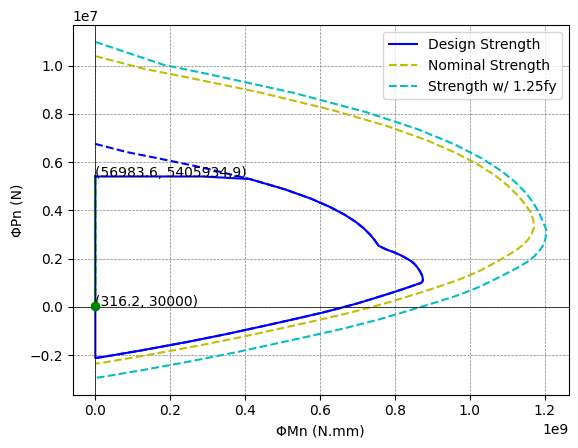

In [503]:
plt.plot(x_Phi1 + [x_Phi1[0]], y_Phi1 + [y_Phi1[0]], label='Design Strength', color='b')
plt.plot(x_Phi2, y_Phi2, linestyle='--', color ='b')
plt.plot(x_NoPhi, y_NoPhi, label='Nominal Strength', linestyle='--',color='y')
plt.plot(x_fymodi, y_fymodi, label='Strength w/ 1.25fy', linestyle='--',color='c')
if PM_information == 'OK' : 
    plt.plot([0, ΦMn_r], [0, ΦPn_r], linestyle='--', color ='g')
else : 
    plt.plot([0, Mu], [0, Pu], linestyle='--', color ='r')
# plt.plot(x_SAP_0degree, y_SAP_0degree, linestyle='--',color='g', marker = 'o', label='SAP_0degree')
# plt.plot(x_SAP_30degree, y_SAP_30degree, linestyle='--',color='y', marker = 'o', label='SAP_30degree')
# plt.plot(x_SAP_75degree, y_SAP_75degree, linestyle='--',color='k', marker = 'o', label='SAP_75degree')
# plt.plot(x_SAP_90degree, y_SAP_90degree, linestyle='--',color='k', marker = 'o', label='SAP_75degree')

plt.scatter(*point, color='g' if PM_information == 'OK' else 'r', zorder=5)
plt.annotate(f'({round(point[0],1)}, {round(point[1],1)})', xy=(point[0], point[1]), xytext=(point[0]+0.5, point[1]+0.5))
plt.annotate(f'({round(ΦMn_r,1)}, {round(ΦPn_r,1)})', xy=(ΦMn_r, ΦPn_r), xytext=(ΦMn_r+0.5, ΦPn_r+0.5))

plt.legend()
plt.xlabel('ΦMn (N.mm)')
plt.ylabel('ΦPn (N)')
plt.axhline(0, color='black', linewidth=0.5)
plt.axvline(0, color='black', linewidth=0.5)
plt.grid(color = 'gray', linestyle = '--', linewidth = 0.5)
plt.show()

In [504]:
def Find_Tension_Reinforcement(RebarDict) :
    XTens = []
    YTens = []
    n = len(Rebararr)
    
    for i in range(n) : 
        for j in range(Rebararr[i]) :
            key = f'Bar_{i}_{j}'
            if RebarDict[key]['X_Coord'] < -b/6 : 
                XTens.append(RebarDict[key]['X_Coord'])
            else : 
                pass

    for i in range(n) : 
        for j in range(Rebararr[i]) :
            key = f'Bar_{i}_{j}'
            if RebarDict[key]['Y_Coord'] < -d/6 : 
                YTens.append(RebarDict[key]['Y_Coord'])
            else : 
                pass
    
    return len(XTens)*As, len(YTens)*As

def Calculate_Shear_Capacity(fy, fc, b, d, beff, deff, XTieLeg, YTieLeg, TieSpace, XTensArea, YTensArea) :
    PhiV = 0.75

    Avxmin = max(0.062*math.sqrt(fc)*d*TieSpace/fy, 0.35*d/fy)
    Avymin = max(0.062*math.sqrt(fc)*b*TieSpace/fy, 0.35*b/fy)
    Avx = Asv*XTieLeg
    Avy = Asv*YTieLeg

    𝜌wx = XTensArea/(d*beff)
    𝜌wy = YTensArea/(b*deff)

    Vcxmax = 0.42*math.sqrt(fc)*d*beff
    Vcymax = 0.42*math.sqrt(fc)*b*deff
    Vcx1 = (0.17*math.sqrt(fc)+min(Pu/(6*Ag), 0.05*fc))*d*beff
    Vcy1 = (0.17*math.sqrt(fc)+min(Pu/(6*Ag), 0.05*fc))*b*deff
    Vcx2 = (0.66*𝜌wx**(1/3)*math.sqrt(fc)+min(Pu/(6*Ag), 0.05*fc))*d*beff
    Vcy2 = (0.66*𝜌wy**(1/3)*math.sqrt(fc)+min(Pu/(6*Ag), 0.05*fc))*b*deff
    Vcx3 = (0.66*min(math.sqrt(2/(1+0.004*beff)),1)*𝜌wx**(1/3)*math.sqrt(fc)+min(Pu/(6*Ag), 0.05*fc))*d*beff
    Vcy3 = (0.66*min(math.sqrt(2/(1+0.004*deff)),1)*𝜌wy**(1/3)*math.sqrt(fc)+min(Pu/(6*Ag), 0.05*fc))*b*deff
    if Avx > Avxmin and Avy > Avymin : 
        Vcx = min(Vcxmax, Vcx1, Vcx2)
        Vcy = min(Vcymax, Vcy1, Vcy2)
    elif Avx > Avxmin and Avy < Avymin : 
        Vcx = min(Vcxmax, Vcx1, Vcx2)
        Vcy = min(Vcymax, Vcy3)
    elif Avx < Avxmin and Avy > Avymin : 
        Vcx = min(Vcxmax, Vcx3)
        Vcy = min(Vcymax, Vcy1, Vcy2)
    elif Avx < Avxmin and Avy < Avymin : 
        Vcx = min(Vcxmax, Vcx3)
        Vcy = min(Vcymax, Vcy3)
    
    ΦVcx = PhiV*Vcx
    ΦVcy = PhiV*Vcy

    Vsxmax = 0.66*math.sqrt(fc)*d*beff
    Vsymax = 0.66*math.sqrt(fc)*b*deff
    Vsx1 = Avx*fy*beff/TieSpace
    Vsy1 = Avy*fy*deff/TieSpace
    Vsx = min(Vsxmax, Vsx1)
    Vsy = min(Vsymax, Vsy1)

    ΦVsx = PhiV*Vsx
    ΦVsy = PhiV*Vsy

    ΦVnx = PhiV*(Vcx+Vsx)
    ΦVny = PhiV*(Vcy+Vsy)

    return Avxmin, Avymin, Avx, Avy, ΦVcx, ΦVcy, ΦVsx, ΦVsy, ΦVnx, ΦVny

XTensArea, YTensArea = Find_Tension_Reinforcement(RebarDict)
Avxmin, Avymin, Avx, Avy, ΦVcx, ΦVcy, ΦVsx, ΦVsy, ΦVnx, ΦVny = Calculate_Shear_Capacity(fy, fc, b, d, beff, deff, XTieLeg, YTieLeg, TieSpace, XTensArea, YTensArea)

In [505]:
############## Output 확인용 ###############

Smax = min(16*Rebardia, 48*Tiedia, b, d)

if ΦVcx/2 > abs(Vux) : 
    print("X dir Transverse Reinforcement is not Required")
elif ΦVcx/2 < abs(Vux) :
    if Smax >= TieSpace : 
        print("S = " + str(round(TieSpace,3)) + " <= Smax = " + str(round(Smax,3)) + " - OK")
    if Smax < TieSpace : 
        print("S = " + str(round(TieSpace,3)) + " > Smax = " + str(round(Smax,3)) + " - NG")
    if Avx >= Avxmin : 
        print("Avx = " + str(round(Avx,3)) + " >= Avxmin = " + str(round(Avxmin,3)) + " - OK")
    if Avx < Avxmin : 
        print("Avx = " + str(round(Avx,3)) + " < Avxmin = " + str(round(Avxmin,3)) + " - NG")
    print("ΦVnx = " + str(round(ΦVnx,3)) + " N   " + "Vux = " + str(round(abs(Vux),3)) + " N   " + "ratio = " + str(abs(Vux)/ΦVnx))
    

if ΦVcy/2 > abs(Vuy) : 
    print("Y dir Transverse Reinforcement is not Required")
elif ΦVcy/2 < abs(Vuy) :
    if Smax >= TieSpace : 
        print("S = " + str(round(TieSpace,3)) + " <= Smax = " + str(round(Smax,3)) + " - OK")
    if Smax < TieSpace : 
        print("S = " + str(round(TieSpace,3)) + " > Smax = " + str(round(Smax,3)) + " - NG")
    if Avy >= Avymin : 
        print("Avy = " + str(round(Avy,3)) + " >= Avymin = " + str(round(Avymin,3)) + " - OK")
    if Avy < Avymin : 
        print("Avy = " + str(round(Avy,3)) + " < Avymin = " + str(round(Avymin,3)) + " - NG")
    print("ΦVny = " + str(round(ΦVny,3)) + " N   " + "Vuy = " + str(round(abs(Vuy),3)) + " N   " + "ratio = " + str(abs(Vuy)/ΦVny))

if ΦVnx>Vux and ΦVny>Vuy :
        print("Vux/ΦVnx = " + str(abs(Vux)/ΦVnx) + " < 1 - OK")
        print("Vuy/ΦVny = " + str(abs(Vuy)/ΦVny) + " < 1 - OK")
elif ΦVnx<Vux and ΦVny<Vuy : 
        print("Vux/ΦVnx = " + str(abs(Vux)/ΦVnx) + " > 1 - NG")
        print("Vuy/ΦVny = " + str(abs(Vuy)/ΦVny) + " > 1 - NG")
elif ΦVnx<Vux and ΦVny>Vuy : 
        print("Vux/ΦVnx = " + str(abs(Vux)/ΦVnx) + " > 1 - NG")
        print("Vuy/ΦVny = " + str(abs(Vuy)/ΦVny) + " < 1 - OK")
elif ΦVnx>Vux and ΦVny<Vuy :
        print("Vux/ΦVnx = " + str(abs(Vux)/ΦVnx) + " < 1 - OK")
        print("Vuy/ΦVny = " + str(abs(Vuy)/ΦVny) + " > 1 - NG")

############## Output 확인용 ###############

X dir Transverse Reinforcement is not Required
Y dir Transverse Reinforcement is not Required
Vux/ΦVnx = 0.0 < 1 - OK
Vuy/ΦVny = 0.0 < 1 - OK
